In [1]:
import os
import argparse

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision

from PIL import Image
from torchvision import transforms

here you can find a checkpoint of deeplab trained on coco + scannet
(without towels and the 3 other-* classes):

In [2]:
BASE = '/home/he/projects/cl_seg/src/deeplab'
RESUME = '2987_deeplab_scannet_best.pth'

In [3]:
model = torchvision.models.segmentation.deeplabv3_resnet101(
    pretrained=False,
    pretrained_backbone=False,
    progress=True,
    num_classes=40,
    aux_loss=None)
ckpt_path = os.path.join(BASE, RESUME)
checkpoint = torch.load(ckpt_path)
# remove any aux classifier stuff
removekeys = [
    key for key in checkpoint.keys() if key.startswith('aux_classifier')
]
for key in removekeys:
    del checkpoint[key]
model.load_state_dict(checkpoint, strict=True)
model.to('cuda')
model.eval()
print("Loaded!")

Loaded!


- output: `(4): Conv2d(256, 40, kernel_size=(1, 1), stride=(1, 1))`

- reference: https://pytorch.org/hub/pytorch_vision_deeplabv3_resnet101/

In [4]:
SCANNET_FRAMES_25K_PATH = '/home/he/data/cl_seg/scannet/scannet_frames_25k'
SCENE = 'scene0000_00'
EXAMPLE_IMG = '000000' # from 000000 to 005500

In [5]:
color_img_name = os.path.join(SCANNET_FRAMES_25K_PATH, SCENE, 'color', EXAMPLE_IMG+'.jpg')
lbl_img_name = os.path.join(SCANNET_FRAMES_25K_PATH, SCENE, 'label', EXAMPLE_IMG+'.png')

In [6]:
_imagenet_stats = {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}

- without Normalize()

In [7]:
# sample execution (requires torchvision)
input_image = Image.open(color_img_name)
input_image = input_image.convert("RGB")
preprocess = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=_imagenet_stats['mean'], std=_imagenet_stats['std']),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

# make a prediction
with torch.no_grad():
    output = model(input_batch)['out'][0]
class_predictions = output.argmax(0)

# logits = model(image)['out']
# _, prediction = torch.max(logits, 1)
_, prediction = torch.max(output, 0)

In [8]:
# input_image_np = np.asarray(input_image)
# input_image_np

In [9]:
#input_batch
input_batch.shape
# max_pixels = torch.max(input_batch, 1)
min_pixels = torch.amin(input_batch, dim=(2, 3))
max_pixels = torch.amax(input_batch, dim=(2, 3))
# max_pixels[0].shape

In [10]:
min_pixels[0], max_pixels[0]

(tensor([0., 0., 0.], device='cuda:0'), tensor([1., 1., 1.], device='cuda:0'))

In [11]:
max_pixels[0].shape

torch.Size([3])

In [12]:
# max_pixels= torch.max(input_batch, 1)
max_pixels= torch.max(input_batch)
max_pixels

tensor(1., device='cuda:0')

- map to [0, 1]

ref: https://stackoverflow.com/questions/65469814/convert-image-to-tensor-with-range-0-255-instead-of-0-1

In [38]:
# sample execution (requires torchvision)
input_image = Image.open(color_img_name)
input_image = input_image.convert("RGB")
preprocess1 = transforms.Compose([
    transforms.ToTensor(),
    # lambda x: x/255,
    transforms.Normalize(mean=(0,)*3, std=(255,)*3),
])

input_tensor1 = preprocess1(input_image)
input_batch1 = input_tensor1.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch1 = input_batch1.to('cuda')
    model.to('cuda')

# make a prediction
with torch.no_grad():
    output1 = model(input_batch1)['out'][0]
class_predictions1 = output1.argmax(0)

# logits = model(image)['out']
# _, prediction = torch.max(logits, 1)
_, prediction1 = torch.max(output1, 0)

- with Normalize()

In [36]:
preprocess2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=_imagenet_stats['mean'], std=_imagenet_stats['std']),
])

input_tensor2 = preprocess2(input_image)
input_batch2 = input_tensor2.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch2 = input_batch2.to('cuda')
    model.to('cuda')

# make a prediction
with torch.no_grad():
    output2 = model(input_batch2)['out'][0]
class_predictions2 = output2.argmax(0)

# logits = model(image)['out']
# _, prediction = torch.max(logits, 1)
_, prediction2 = torch.max(output2, 0)

In [37]:
output.shape
output[0,:, :]

tensor([[-4.7141, -4.7141, -4.7141,  ..., -4.0566, -4.0566, -4.0566],
        [-4.7141, -4.7141, -4.7141,  ..., -4.0566, -4.0566, -4.0566],
        [-4.7141, -4.7141, -4.7141,  ..., -4.0566, -4.0566, -4.0566],
        ...,
        [-5.7391, -5.7391, -5.7391,  ..., -5.8906, -5.8906, -5.8906],
        [-5.7391, -5.7391, -5.7391,  ..., -5.8906, -5.8906, -5.8906],
        [-5.7391, -5.7391, -5.7391,  ..., -5.8906, -5.8906, -5.8906]],
       device='cuda:0')

In [31]:
from viz_label import create_color_palette

- viz without Normalize()

In [32]:
prediction_np = class_predictions.cpu().detach()
print(np.unique(prediction_np))

[ 0  1  3  4  5  6  7  9 13 14 16 20 21 31 34 36]


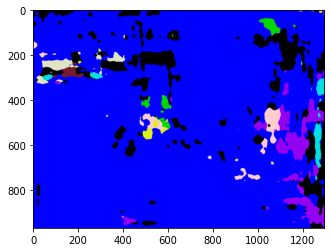

In [33]:
image = class_predictions.cpu().detach()
height = image.shape[0]
width = image.shape[1]
vis_image = np.zeros([height, width, 3], dtype=np.uint8)
color_palette = create_color_palette(dataset='nyu40')
for idx, color in enumerate(color_palette):
    vis_image[image == idx] = color

plt.imshow(vis_image)

- viz with mapping to [0, 1]

In [39]:
prediction_np = class_predictions1.cpu().detach()
print(np.unique(prediction_np))

[ 0  1  3  4  5  6  8 10 13 14 15 16 17 18 20 24 30 31 34]


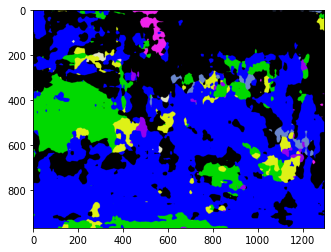

In [40]:
image = class_predictions1.cpu().detach()
height = image.shape[0]
width = image.shape[1]
vis_image = np.zeros([height, width, 3], dtype=np.uint8)
color_palette = create_color_palette(dataset='nyu40')
for idx, color in enumerate(color_palette):
    vis_image[image == idx] = color

plt.imshow(vis_image)

- viz with Normalize()

In [22]:
prediction_np = class_predictions2.cpu().detach()
print(np.unique(prediction_np))

[ 0  1  2  4  6 23]


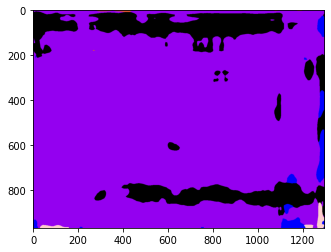

In [23]:
image = class_predictions2.cpu().detach()
height = image.shape[0]
width = image.shape[1]
vis_image = np.zeros([height, width, 3], dtype=np.uint8)
color_palette = create_color_palette(dataset='nyu40')
for idx, color in enumerate(color_palette):
    vis_image[image == idx] = color

plt.imshow(vis_image)

- vis label image

In [24]:
lbl_image = Image.open(lbl_img_name)
lbl_image = np.asarray(lbl_image)
lbl_image
print(np.unique(lbl_image))

[ 0  1  2  3  7 14 16]


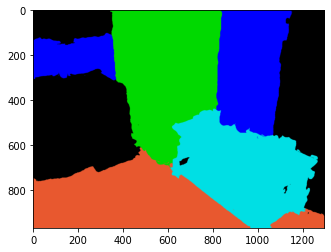

In [25]:

height = lbl_image.shape[0]
width = lbl_image.shape[1]
lbl_vis_image = np.zeros([height, width, 3], dtype=np.uint8)
color_palette = create_color_palette(dataset='nyu40')
for idx, color in enumerate(color_palette):
    lbl_vis_image[lbl_image == idx] = color

plt.imshow(lbl_vis_image)

In [26]:
# import imageio
# imageio.imwrite(filename, vis_image)

In [27]:
# # create a color pallette, selecting a color for each class
# palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
# colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
# colors = (colors % 255).numpy().astype("uint8")

# # plot the semantic segmentation predictions of 21 classes in each color
# r = Image.fromarray(class_predictions.byte().cpu().numpy()).resize(input_image.size)
# r.putpalette(colors)

# plt.imshow(r)